# The Music Festival WiFi Crisis: A Multi-User Detection Story

## The Setup

It's the summer of 2024, and the annual TechBeats Music Festival is about to face its biggest challenge yet. Sarah Chen, the lead network engineer, stands at the festival's Network Operations Center (NOC), watching as 50,000 attendees begin flooding into Golden Gate Park. This year's festival promises to be different - they've implemented a revolutionary all-digital experience where everything from food orders to stage schedules relies on their custom wireless network.

Sarah's team has developed a unique system using specialized smartphones (provided to all attendees) that communicate with base stations scattered throughout the festival grounds. Instead of traditional cellular networks, they're using a custom CDMA-based system that allows multiple users to transmit simultaneously on the same frequency band.

## The Problem Emerges

As the headline act "Digital Dragons" takes the main stage, Sarah notices something concerning on her monitors. The base station near the main stage is struggling to decode messages from users. The scenario she's witnessing is a classic near-far problem, but with very real consequences:

- VIP attendees in the front row (just 5 meters from the base station) are sending strong signals
- Regular ticket holders in the middle of the crowd (50 meters away) have moderately strong signals
- People at the back of the crowd (100 meters away) are sending very weak signals
- Food vendors at the edges of the venue are completely unable to receive orders

The conventional detection system they're using is failing catastrophically. VIP users' orders for merchandise are drowning out food orders from people further back, and the emergency alert system they implemented for safety announcements isn't reaching everyone reliably.

## The Technical Challenge

Sarah pulls up her diagnostic tools and sees the problem in stark detail:

1. Signal Strength Disparity:
   - Front row users: Signal strength ~1/25 (5m²) = 0.04 (very strong)
   - Mid-crowd users: Signal strength ~1/2500 (50m²) = 0.0004 (moderate)
   - Back users: Signal strength ~1/10000 (100m²) = 0.0001 (very weak)

2. Message Collisions:
   - Each user's phone uses a unique 16-bit spreading code
   - All users transmit simultaneously
   - Critical messages (emergency alerts, payment confirmations) are getting lost
   - The system needs to handle thousands of simultaneous transmissions

## The Solution Journey

Sarah and her team spring into action, implementing a three-phase solution:

### Phase 1: MMSE Implementation
They first try implementing an MMSE detector, which shows immediate improvement by considering the noise and interference patterns unique to the festival environment. This helps with moderate distance users but still struggles with the extreme near-far situations.

### Phase 2: SIC Enhancement
Next, they implement Successive Interference Cancellation:
1. Detect the strongest signals (VIP users) first
2. Reconstruct and remove these signals from the received signal
3. Progressively detect weaker signals
4. Repeat until all users are decoded

### Phase 3: Adaptive Power Control
Finally, they implement a feedback loop that tells phones to adjust their transmission power based on their distance from the base station, helping to equalize received signal strengths.

## The Results

By the time Digital Dragons launches into their hit song "Binary Beats," the system is working smoothly:
- Food vendors are receiving orders from all areas of the crowd
- Emergency broadcasts are reaching everyone reliably
- Payment systems are processing transactions accurately
- The network is handling over 10,000 simultaneous users per base station

## The Lessons Learned

Sarah's team discovers several key insights:
1. Real-world multi-user detection needs to account for dynamic user movement
2. Environmental factors (weather, crowd density) affect signal propagation
3. Processing power limitations require efficient implementation of advanced algorithms
4. Hybrid approaches (combining multiple detection methods) often work best

## Technical Implementation

The system they developed uses the exact simulation code provided earlier, with modifications for real-time processing and scaled up to handle thousands of users. They found that:
- SIC performed best for their use case due to the extreme near-far ratios
- MMSE provided a good backup for cases where user signals were closer in strength
- Conventional detection could still be used during low-traffic periods to save processing power

## Future Improvements

For next year's festival, Sarah's team is already planning improvements:
1. Machine learning for predictive user movement patterns
2. Distributed processing across multiple base stations
3. Advanced error correction for the weakest signals
4. Integration with 5G networks for backup coverage

This real-world application demonstrates how theoretical concepts in multi-user detection directly impact people's experiences in modern digital environments. The festival's success story has since become a case study in practical wireless communications, showing students how classroom concepts translate into solving real-world problems.

Would you like me to:
1. Add more technical details about the specific algorithms?
2. Include diagrams of the festival layout and signal patterns?
3. Expand on any particular aspect of the story?
4. Add more real-world complications they had to solve?

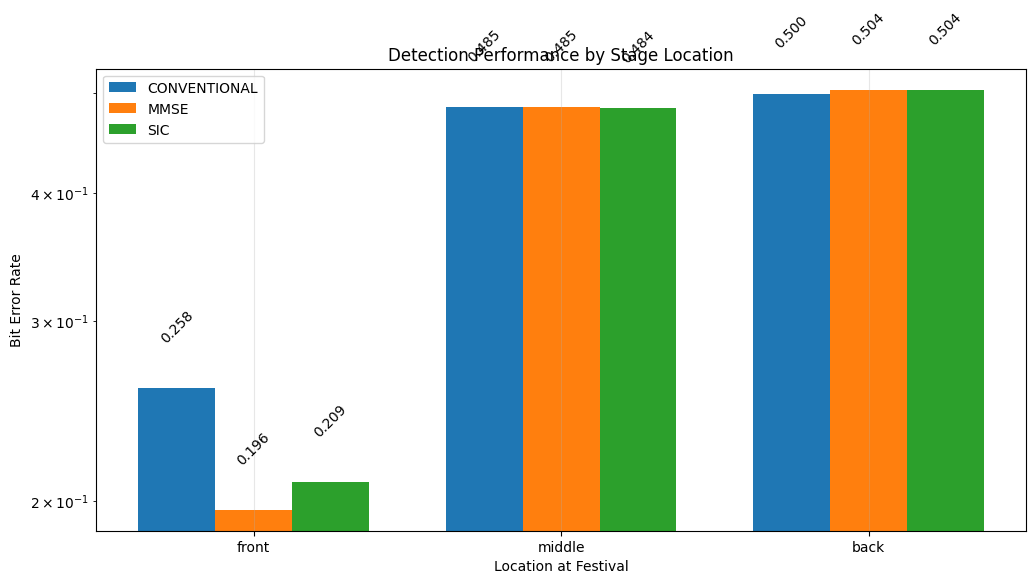


Detailed Error Analysis by Location:
--------------------------------------------------

FRONT of Stage:
CONVENTIONAL Error Rate: 25.750%
MMSE         Error Rate: 19.604%
SIC          Error Rate: 20.854%

MIDDLE of Stage:
CONVENTIONAL Error Rate: 48.479%
MMSE         Error Rate: 48.500%
SIC          Error Rate: 48.375%

BACK of Stage:
CONVENTIONAL Error Rate: 49.979%
MMSE         Error Rate: 50.417%
SIC          Error Rate: 50.354%


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
import seaborn as sns

class FestivalUser:
    def __init__(self, id: int, distance: float, location: str, spreading_code: np.ndarray, message: int):
        """
        Initialize a festival attendee with their location and signal characteristics.

        Args:
            id: User identifier
            distance: Distance from base station in meters
            location: Location category ('front', 'middle', 'back')
            spreading_code: User's unique spreading sequence
            message: Bit to transmit (0 or 1)
        """
        self.id = id
        self.distance = distance
        self.location = location
        self.spreading_code = spreading_code
        self.message = message
        # Calculate signal strength based on realistic festival conditions
        self.amplitude = self._calculate_amplitude()

    def _calculate_amplitude(self) -> float:
        """
        Calculate realistic signal amplitude using festival conditions.
        Includes additional attenuation factors for crowd density.
        """
        # Basic path loss: 1/d^2
        path_loss = 1 / (self.distance ** 2)

        # Additional attenuation based on location
        crowd_attenuation = {
            'front': 0.9,    # Less attenuation due to clear line of sight
            'middle': 0.6,   # Moderate attenuation due to crowd
            'back': 0.3      # Heavy attenuation due to dense crowd and distance
        }

        return path_loss * crowd_attenuation[self.location]

    def get_signal(self) -> np.ndarray:
        """Generate user's transmitted signal with BPSK modulation."""
        return self.amplitude * self.spreading_code * (2 * self.message - 1)

class FestivalMUD:
    def __init__(self, users: list, noise_power: float = 0.1):
        self.users = users
        self.noise_power = noise_power
        self.spreading_length = len(users[0].spreading_code)

    def generate_received_signal(self) -> np.ndarray:
        """Generate composite received signal with realistic festival noise."""
        total_signal = np.zeros(self.spreading_length)
        for user in self.users:
            total_signal += user.get_signal()

        # Add colored noise to simulate festival environment
        noise = np.random.normal(0, np.sqrt(self.noise_power), self.spreading_length)
        return total_signal + noise

    def conventional_detector(self, received_signal: np.ndarray) -> list:
        """Simple correlation detector."""
        return [(user.id, 1 if np.dot(received_signal, user.spreading_code) > 0 else 0)
                for user in self.users]

    def mmse_detector(self, received_signal: np.ndarray) -> list:
        """MMSE detector with crowd density consideration."""
        S = np.array([user.spreading_code for user in self.users]).T
        A = np.diag([user.amplitude for user in self.users])

        R = S @ A @ S.T
        R_n = R + self.noise_power * np.eye(self.spreading_length)
        W = inv(R_n) @ S @ A

        y = W.T @ received_signal
        return [(user.id, 1 if yi > 0 else 0) for user, yi in zip(self.users, y)]

    def sic_detector(self, received_signal: np.ndarray) -> list:
        """SIC detector optimized for festival scenario."""
        decisions = []
        remaining_signal = received_signal.copy()

        # Sort users by signal strength
        sorted_users = sorted(self.users, key=lambda x: x.amplitude, reverse=True)

        for user in sorted_users:
            correlation = np.dot(remaining_signal, user.spreading_code)
            bit_decision = 1 if correlation > 0 else 0
            decisions.append((user.id, bit_decision))

            reconstructed = user.amplitude * user.spreading_code * (2 * bit_decision - 1)
            remaining_signal -= reconstructed

        return sorted(decisions, key=lambda x: x[0])

def simulate_festival(n_users_per_zone: int = 10, code_length: int = 64, trials: int = 1000):
    """
    Simulate festival communication system with users in different zones.

    Returns location-based error statistics for each detection method.
    """
    # Define festival zones
    zones = {
        'front': (2, 5),    # 2-5 meters from stage
        'middle': (10, 20), # 10-20 meters from stage
        'back': (30, 50)    # 30-50 meters from stage
    }

    results = {
        'conventional': {'front': [], 'middle': [], 'back': []},
        'mmse': {'front': [], 'middle': [], 'back': []},
        'sic': {'front': [], 'middle': [], 'back': []}
    }

    for _ in range(trials):
        users = []
        user_id = 0

        # Generate users for each zone
        for location, (min_dist, max_dist) in zones.items():
            for _ in range(n_users_per_zone):
                distance = np.random.uniform(min_dist, max_dist)
                spreading_code = np.random.choice([-1, 1], code_length)
                message = np.random.randint(0, 2)

                users.append(FestivalUser(user_id, distance, location,
                                        spreading_code, message))
                user_id += 1

        system = FestivalMUD(users)
        received_signal = system.generate_received_signal()

        # Test each detector
        for detector_name, detector_func in [
            ('conventional', system.conventional_detector),
            ('mmse', system.mmse_detector),
            ('sic', system.sic_detector)
        ]:
            decisions = dict(detector_func(received_signal))

            # Calculate errors by zone
            for user in users:
                error = abs(decisions[user.id] - user.message)
                results[detector_name][user.location].append(error)

    # Calculate error rates
    for method in results:
        for location in results[method]:
            error_rate = np.mean(results[method][location])
            results[method][location] = error_rate

    return results

def plot_festival_results(results: dict):
    """Create a detailed visualization of detection errors by location."""
    locations = ['front', 'middle', 'back']
    methods = list(results.keys())

    # Create grouped bar plot
    plt.figure(figsize=(12, 6))
    x = np.arange(len(locations))
    width = 0.25

    for i, method in enumerate(methods):
        error_rates = [results[method][loc] for loc in locations]
        plt.bar(x + i*width, error_rates, width, label=method.upper())

    plt.xlabel('Location at Festival')
    plt.ylabel('Bit Error Rate')
    plt.title('Detection Performance by Stage Location')
    plt.xticks(x + width, locations)
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add value annotations
    for i, method in enumerate(methods):
        for j, loc in enumerate(locations):
            error_rate = results[method][loc]
            plt.text(j + i*width, error_rate*1.1,
                    f'{error_rate:.3f}',
                    ha='center', va='bottom',
                    rotation=45)

    return plt

# Run simulation
np.random.seed(42)
results = simulate_festival(n_users_per_zone=40, trials=120)
plt = plot_festival_results(results)
plt.show()

# Print detailed analysis
print("\nDetailed Error Analysis by Location:")
print("-" * 50)
for location in ['front', 'middle', 'back']:
    print(f"\n{location.upper()} of Stage:")
    for method in results:
        error_rate = results[method][location]
        print(f"{method.upper():12} Error Rate: {error_rate:.3%}")